# Capability Correlations

Let's start by importing all of the necessary libraries to conduct the analysis. 

In [1]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator


# please add your plotly api credentials to plotly_config in your own machine. Visit https://plot.ly/python/getting-started/
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

## 1. Data gathering <a class="anchor" id="one"></a>

In order to establish a base for understading the basis of the work, we wish to understand the occurence of severall feedstocks, processing technologies and outputs in our database. 

For example, how many assets (patents, papers, etc) contain the mix of processing technology X for output Y? 

To understand this in a more general way, the [AMICA](https://amica-pathfinder.net/) database will be transformed in an [co-occurence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix). This means, in the above described example that the number of assets that contain that mix will be an entry in a matrix, whyle the corresponfing technology and output will be columns/lines of the matrix. 

### 1.1. Axis building <a class="anchor" id="one-one"></a>

In [2]:
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

In [3]:
query_no_interestions = """     MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                RETURN fs.term, pt.term, out.term, count(a)
                        """

In [4]:
# issue: this query needs to be divided by two when building the matrix -> NON OPTIMIZED
process_variables = ['Feedstock', 'Output', 'ProcessingTech']
query_intersections = """       MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                WHERE fs<>t 
                                RETURN fs.term, t.term, count(a)
                      """

In [5]:
# Return query as pandas dataframe 
data_no_intersections = DataFrame(connection_to_graph.data(query_no_interestions)).as_matrix()

# Get axis names from columns and append to list
feedstock_names = set(list(data_no_intersections[:, 1]))
processing_technology_names = set(list(data_no_intersections[:, 2]))
output_names = set(list(data_no_intersections[:, 3]))
matrix_axis_names = list(feedstock_names) + list(processing_technology_names) + list(output_names)

# Extra labels that only appear in non-intersection queries
for category in process_variables:
    data_no_intersections = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    for column_number in range(1,3):
        column = data_no_intersections[:, column_number]
        for name in column:
            if name not in matrix_axis_names:
                matrix_axis_names.append(name)
                
print len(matrix_axis_names)

342


### 1.2. Function Design <a class="anchor" id="one-two"></a>

In [6]:
def get_asset_matrix(asset, normalization=True):
    
    # define queries
    asset_no_interestions = """     MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                    MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                    MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                    WHERE a.type = "{}"
                                    RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(asset)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    asset_intersections = """       MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                    WHERE fs<>t AND a.type = "{}"
                                    RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_no_intersections = DataFrame(connection_to_graph.data(asset_no_interestions)).as_matrix()
    
    # create matrix
    asset_matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])
    
    # for no intersections data
    for row in data_no_intersections:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [matrix_axis_names.index(element) for element in row[1::]]
        # add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            asset_matrix[pair[0], pair[1]] += frequency
            asset_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(asset_intersections.format(category, category, asset))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [matrix_axis_names.index(element) for element in row[1::]]
            # add frequency value to matrix position
            for pair in itertools.combinations(indexes, 2):
                asset_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                asset_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    normalized_asset_matrix = (asset_matrix - np.mean(asset_matrix)) / np.std(asset_matrix)
    
    # dynamic return 
    if normalization == True:
        return normalized_asset_matrix
    else: 
        return asset_matrix

### 1.3. Patents and Publication Matrixes <a class="anchor" id="one-three"></a>

In [7]:
norm_mode = False
publication_matrix = get_asset_matrix('PUBLICATION', normalization=norm_mode)
patent_matrix = get_asset_matrix('PATENT', normalization=norm_mode)

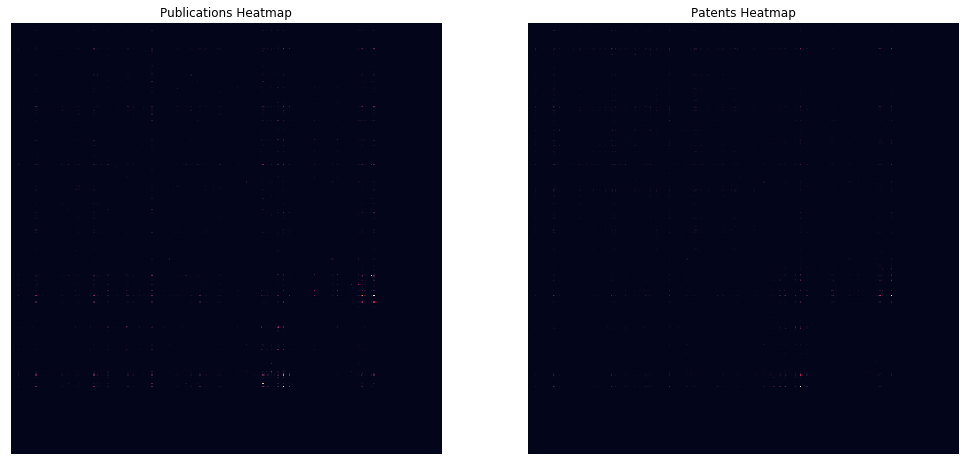

In [8]:
# create subplots
plt.subplots(2,1,figsize=(17,17))

plt.subplot(121)
sns.heatmap(publication_matrix,  cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Publications Heatmap')

plt.subplot(122)
sns.heatmap(patent_matrix, cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Patents Heatmap')
plt.show()

In [9]:
print 'PATENTS:'
print 'Rows:', patent_matrix.shape[0]
print 'Columns:', patent_matrix.shape[1]
print 'Mean: ', np.mean(patent_matrix)
print 'Standart Deviation', np.std(patent_matrix)
print 'Max: ', np.amax(patent_matrix)
print 'Min: ', np.amin(patent_matrix)

PATENTS:
Rows: 342
Columns: 342
Mean:  0.7012927054478301
Standart Deviation 6.683876527537948
Max:  883.0
Min:  0.0


In [10]:
print 'PUBLICATIONS:'
print 'Rows:', publication_matrix.shape[0]
print 'Columns:', publication_matrix.shape[1]
print 'Mean: ', np.mean(publication_matrix)
print 'Standart Deviation', np.std(publication_matrix)
print 'Max: ', np.amax(publication_matrix)
print 'Min: ', np.amin(publication_matrix)

PUBLICATIONS:
Rows: 342
Columns: 342
Mean:  1.963835026161896
Standart Deviation 22.45221872398744
Max:  2169.0
Min:  0.0


## 2. Patents and Publication Matrixes: Differences <a class="anchor" id="two"></a>

In [11]:
differences = patent_matrix - publication_matrix

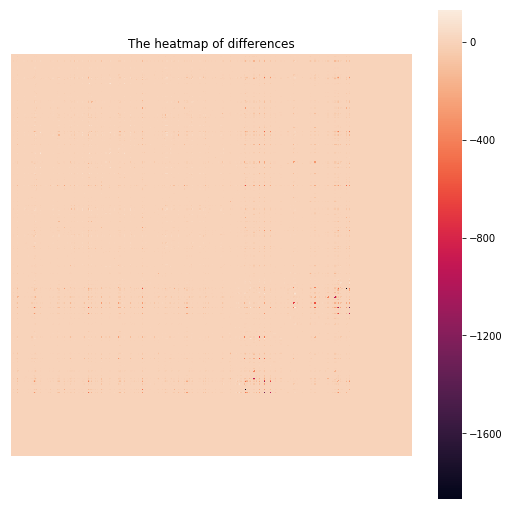

In [12]:
plt.subplots(1,1,figsize=(9,9))

plt.subplot(111)
sns.heatmap(differences, square=True, xticklabels=False, yticklabels=False)
plt.title('The heatmap of differences')
plt.show()

## 3. Patents and Publication Matrixes: Chronological Evolution <a class="anchor" id="two"></a>

### 3.1. Getting the total documentation for an asset type <a class="anchor" id="three-one"></a>

We start by creating a function that given a certain asset type and a timeline, returns the number of documents of that type for every year. 

In [13]:
def getTotalDocuments(assetType, startYear, endYear):
    assetQuery = """MATCH (a:Asset)
                    WHERE  a.type="{}"
                    AND toInteger(a.year)>={} AND toInteger(a.year)<={} 
                    AND NOT a.year = "Null"
                    RETURN  a.year, count(a)
                    ORDER BY a.year""".format(assetType, startYear, endYear)
    
    dataReturn = DataFrame(connection_to_graph.data(assetQuery)).as_matrix()
    timeLine = np.arange(startYear, endYear + 1)
    finalMatrix = np.transpose(np.vstack((timeLine, timeLine)))
    
    for i in range(finalMatrix.shape[0]):
        finalMatrix[i, 1] = 0
        for j in range(dataReturn.shape[0]):
            if finalMatrix[i, 0] == int(dataReturn[j, 0]):
                finalMatrix[i, 1] = dataReturn[j, 1]
                
    toReturn = {}
    
    toReturn['Years'] = finalMatrix[:, 0]
    toReturn['Quantity'] = finalMatrix[:, 1]
                
    return toReturn    

We now test the function

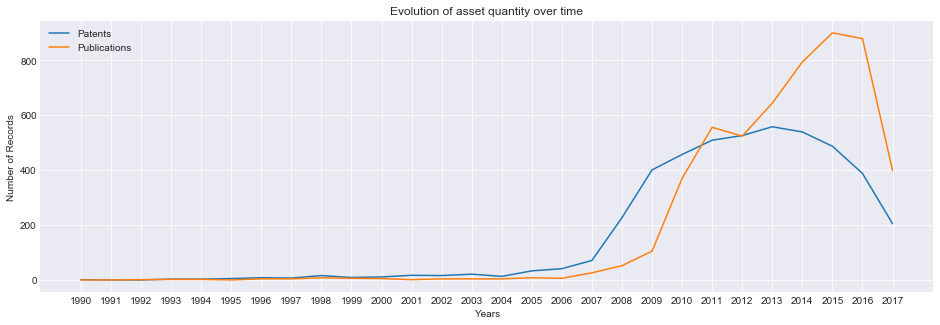

In [14]:
# define data 
startYear = 1990
endYear = 2017
patentTimeline = getTotalDocuments('PATENT', startYear, endYear)
publicationTimeline = getTotalDocuments('PUBLICATION', startYear, endYear)
title = 'Evolution of asset quantity over time'
x_label = 'Years'
y_label = 'Number of Records'

# plot evolution
plt.style.use('seaborn-darkgrid')
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.plot(patentTimeline['Years'], patentTimeline['Quantity'], label='Patents')
plt.plot(publicationTimeline['Years'], publicationTimeline['Quantity'], label='Publications')
plt.legend()
plt.xticks(publicationTimeline['Years'])
plt.title('Evolution of asset quantity over time')
plt.xlabel('Years') 
plt.ylabel('Number of Records') 
plt.show()

### 3.2. Comparing the chronological evolution of asset types <a class="anchor" id="three-one"></a>

A function that gives the chronological evolution of a certain asset. 

In [15]:
def getDocuments(processType, processTerm, assetType, startYear, endYear):
    assetQuery = """MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                    WHERE  fs.term = "{}" AND a.type="{}"
                    AND toInteger(a.year)>={} AND toInteger(a.year)<={} 
                    AND NOT a.year = "Null"
                    RETURN  a.year, count(a)
                    ORDER BY a.year""".format(processType, processTerm, assetType, startYear, endYear)
    
    dataReturn = DataFrame(connection_to_graph.data(assetQuery)).as_matrix()
    timeLine = np.arange(startYear, endYear + 1)
    finalMatrix = np.transpose(np.vstack((timeLine, timeLine)))
    
    for i in range(finalMatrix.shape[0]):
        finalMatrix[i, 1] = 0
        for j in range(dataReturn.shape[0]):
            if finalMatrix[i, 0] == int(dataReturn[j, 0]):
                finalMatrix[i, 1] = dataReturn[j, 1]
                
    toReturn = {}
    
    toReturn['Years'] = finalMatrix[:, 0]
    toReturn['Quantity'] = finalMatrix[:, 1]
                
    return toReturn    

We then test the function for severall different values of Feedstocks, in this case, the ones that are more proiminent in the database. 

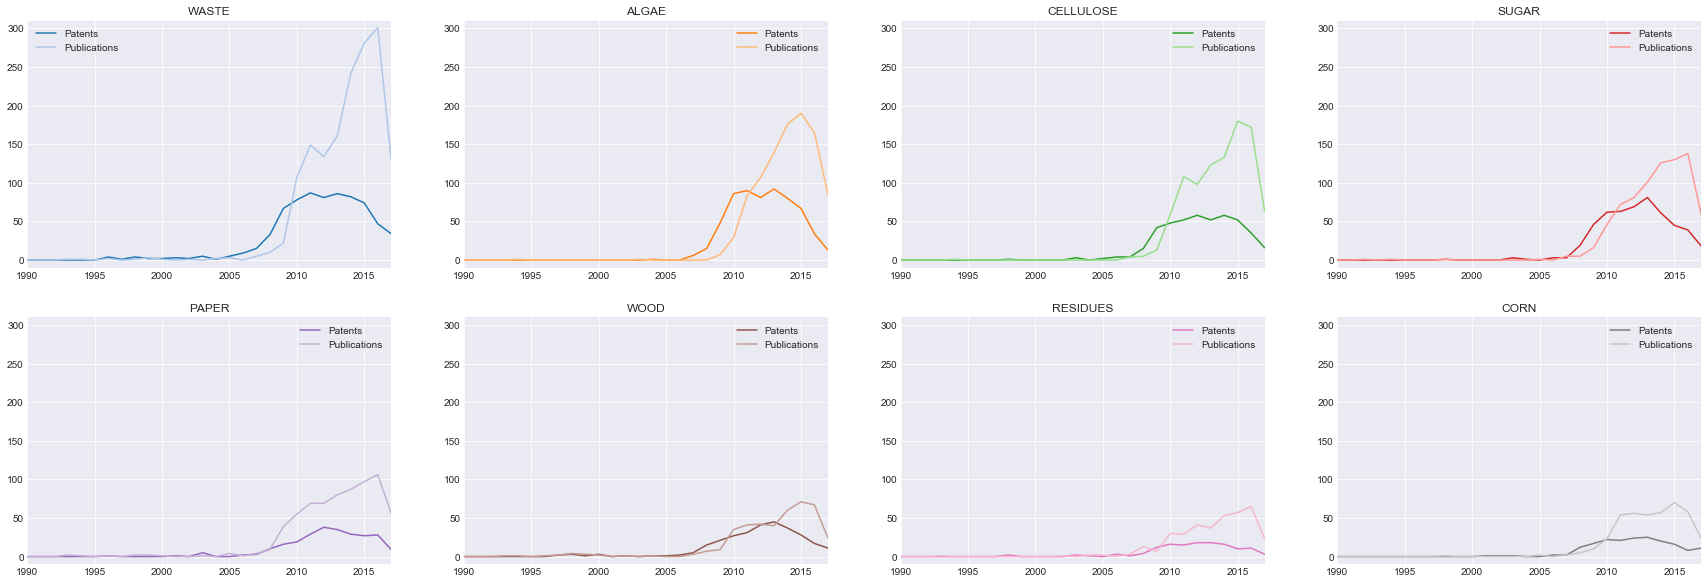

In [16]:
feedstockList = ['waste', 'algae', 'cellulose', 'sugar', 'paper', 'wood', 'residues', 'corn']

palette = plt.get_cmap('tab20')
plotCounter = 1
colorCounter = 0
plt.subplots(1,1,figsize=(30, 10))

for term in feedstockList:
    termPat = getDocuments('Feedstock', term, 'PATENT', 1990, 2017)
    termPub = getDocuments('Feedstock', term, 'PUBLICATION', 1990, 2017)
    plt.subplot(2,4, plotCounter)
    plt.plot(termPat['Years'], termPat['Quantity'], label = 'Patents', color = palette(colorCounter))
    plt.plot(termPub['Years'], termPub['Quantity'], label = 'Publications', color = palette(colorCounter + 1))
    plt.xlim(1990,2017)
    plt.ylim(-10,310)
    plt.title(term.upper())
    plt.legend()
    plotCounter += 1
    colorCounter += 2
    
plt.show()

What about outputs as process variables? 

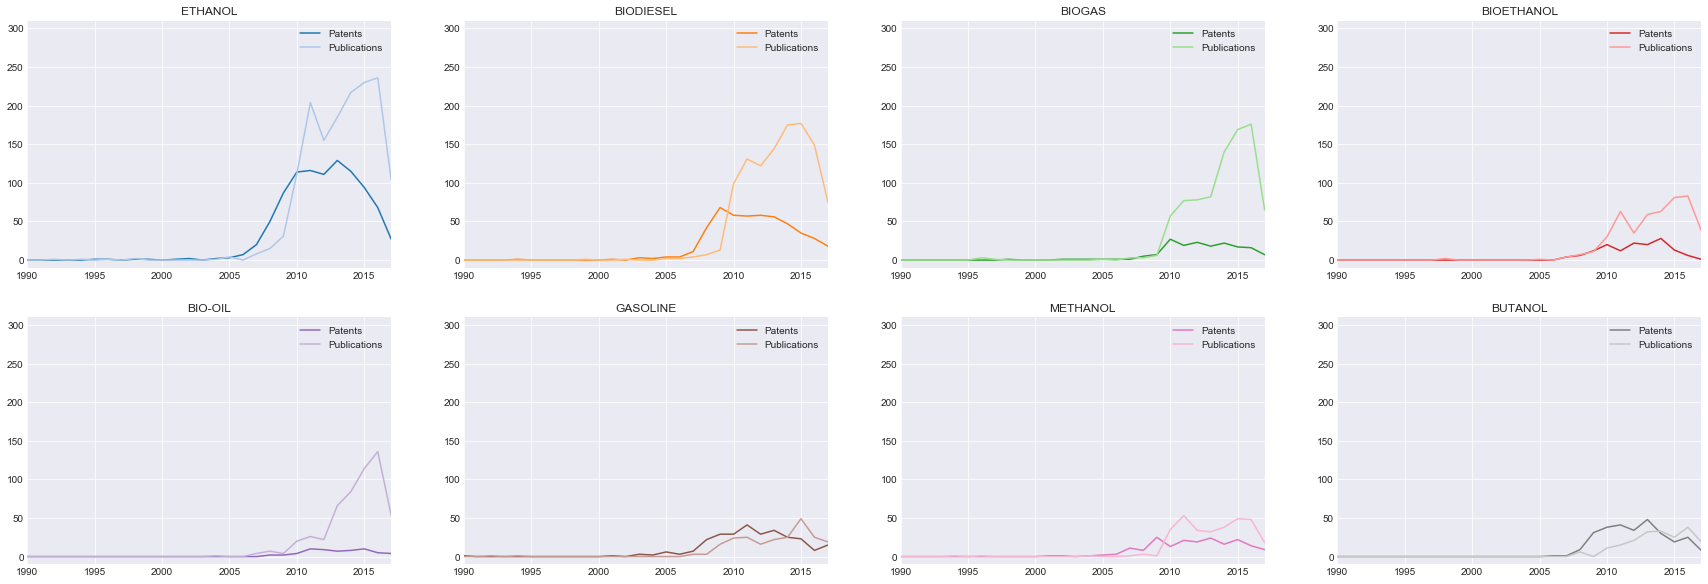

In [17]:
outputList = ["ethanol", "biodiesel", "biogas", "bioethanol", "bio-oil", "gasoline", "methanol", "butanol"]

palette = plt.get_cmap('tab20')
plotCounter = 1
colorCounter = 0
plt.subplots(1,1,figsize=(30, 10))

for term in outputList:
    termPat = getDocuments('Output', term, 'PATENT', 1990, 2017)
    termPub = getDocuments('Output', term, 'PUBLICATION', 1990, 2017)

    plt.subplot(2,4, plotCounter)
    plt.plot(termPat['Years'], termPat['Quantity'], label = 'Patents', color = palette(colorCounter))
    plt.plot(termPub['Years'], termPub['Quantity'] , label = 'Publications', color = palette(colorCounter + 1))
    plt.xlim(1990,2017)
    plt.ylim(-10,310)
    plt.title(term.upper())
    plt.legend()
    plotCounter += 1
    colorCounter += 2
    
plt.show()